In [1]:
import tensorflow as tf

2025-08-09 19:10:30.585926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754766630.794787      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754766630.855945      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert tf.config.list_physical_devices('GPU'), "No GPU detected: Check your Kaggle environment settings."

Num GPUs Available: 1


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set paths
SRC_ROOT = '/kaggle/input/cwd30-corn-weeds-weeks/data_filtered_by_weeks'  # Your filtered dataset directory
DST_ROOT = '/kaggle/working/data_final_split'

# Define split ratios
TRAIN_RATIO = 0.60 
VAL_RATIO = 0.20    
TEST_RATIO = 0.20   

# Create output directories
os.makedirs(DST_ROOT, exist_ok=True)

train_dir = os.path.join(DST_ROOT, 'train')
val_dir = os.path.join(DST_ROOT, 'val')
test_dir = os.path.join(DST_ROOT, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Statistics tracking
split_stats = {}

# Get all classes (weed_week combinations)
classes = [d for d in os.listdir(SRC_ROOT) if os.path.isdir(os.path.join(SRC_ROOT, d))]

print("Splitting dataset with stratification...")

for cls in classes:
    class_src_path = os.path.join(SRC_ROOT, cls)
    images = [f for f in os.listdir(class_src_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Skip classes with too few images
    if len(images) < 5:
        print(f"Warning: {cls} has only {len(images)} images, skipping...")
        continue
    
    # Split images into train+val and test first
    train_val_imgs, test_imgs = train_test_split(
        images, test_size=TEST_RATIO, random_state=42, shuffle=True
    )
    
    # Then split train+val into train and val
    val_size_adjusted = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
    train_imgs, val_imgs = train_test_split(
        train_val_imgs, test_size=val_size_adjusted, random_state=42, shuffle=True
    )
    
    # Create class directories for each split
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    
    # Copy files to respective directories
    for img in train_imgs:
        shutil.copy2(os.path.join(class_src_path, img), os.path.join(train_dir, cls, img))
    
    for img in val_imgs:
        shutil.copy2(os.path.join(class_src_path, img), os.path.join(val_dir, cls, img))
    
    for img in test_imgs:
        shutil.copy2(os.path.join(class_src_path, img), os.path.join(test_dir, cls, img))
    
    # Track statistics
    split_stats[cls] = {
        'total': len(images),
        'train': len(train_imgs),
        'val': len(val_imgs),
        'test': len(test_imgs)
    }

# Print split statistics
print("\n" + "="*60)
print("SPLIT STATISTICS")
print("="*60)

total_train = total_val = total_test = 0

for cls, stats in split_stats.items():
    print(f"{cls}:")
    print(f"  Total: {stats['total']} | Train: {stats['train']} | Val: {stats['val']} | Test: {stats['test']}")
    total_train += stats['train']
    total_val += stats['val'] 
    total_test += stats['test']

print("="*60)
print(f"OVERALL: Train: {total_train} | Val: {total_val} | Test: {total_test}")
print(f"Ratios: Train: {total_train/(total_train+total_val+total_test):.2%} | Val: {total_val/(total_train+total_val+total_test):.2%} | Test: {total_test/(total_train+total_val+total_test):.2%}")

print(f"\nDataset split completed! Check: {DST_ROOT}")


Splitting dataset with stratification...

SPLIT STATISTICS
cockspur-grass_w5:
  Total: 1399 | Train: 839 | Val: 280 | Test: 280
fall-panicum_w1:
  Total: 1445 | Train: 867 | Val: 289 | Test: 289
cockspur-grass_w1:
  Total: 1430 | Train: 858 | Val: 286 | Test: 286
finger-grass_w5:
  Total: 1400 | Train: 840 | Val: 280 | Test: 280
cockspur-grass_w2:
  Total: 1430 | Train: 858 | Val: 286 | Test: 286
fall-panicum_w0:
  Total: 1365 | Train: 819 | Val: 273 | Test: 273
cockspur-grass_w3:
  Total: 1489 | Train: 893 | Val: 298 | Test: 298
finger-grass_w0:
  Total: 1350 | Train: 810 | Val: 270 | Test: 270
cockspur-grass_w0:
  Total: 1349 | Train: 809 | Val: 270 | Test: 270
fall-panicum_w4:
  Total: 1400 | Train: 840 | Val: 280 | Test: 280
cockspur-grass_w6:
  Total: 799 | Train: 479 | Val: 160 | Test: 160
fall-panicum_w3:
  Total: 1475 | Train: 885 | Val: 295 | Test: 295
fall-panicum_w2:
  Total: 1445 | Train: 867 | Val: 289 | Test: 289
finger-grass_w4:
  Total: 1400 | Train: 840 | Val: 280 | Te

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
# from keras_flops import get_flops


IMG_SIZE = (224, 224)  # Adjust as needed
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
INITIAL_LR = 0.001
EPOCHS = 100
SEED = 42

train_dir = '/kaggle/working/data_final_split/train'
val_dir = '/kaggle/working/data_final_split/val'
test_dir = '/kaggle/working/data_final_split/test'

datagen_args = dict(rescale=1./255)
train_gen = ImageDataGenerator(**datagen_args)
val_gen = ImageDataGenerator(**datagen_args)
test_gen = ImageDataGenerator(**datagen_args)
train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)
val_flow = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
num_classes = train_flow.num_classes

Found 16697 images belonging to 21 classes.
Found 5568 images belonging to 21 classes.
Found 5568 images belonging to 21 classes.


In [9]:
base_model = DenseNet121(
    include_top=False, 
    weights='imagenet', 
    input_shape=IMG_SIZE + (3,)
)

# Keep base model trainable (as per assignment requirement)
base_model.trainable = True

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(128, activation='relu')(x)

output = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LR, 
    weight_decay=0.01
)

print("Compiling model...")
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


I0000 00:00:1754766875.205376      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Compiling model...


In [11]:
print("\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")


Model Summary:
Total parameters: 8,786,005
Trainable parameters: 8,698,773


In [12]:
checkpoint_cb = ModelCheckpoint(
    "best_densenet_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10,  # Increased patience
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb]

print("Starting training ")

# Train the whole model on your dataset
history = model.fit(
    train_flow,
    epochs=EPOCHS,
    validation_data=val_flow,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Starting training 


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1754767025.735428     159 service.cc:148] XLA service 0x7f9e44003420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754767025.736317     159 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754767036.651688     159 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754767140.207103     159 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


522/522 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1511 - loss: 2.7262
Epoch 1: val_accuracy improved from -inf to 0.23330, saving model to best_densenet_model.h5
522/522 ━━━━━━━━━━━━━━━━━━━━ 460s 439ms/step - accuracy: 0.1512 - loss: 2.7253 - val_accuracy: 0.2333 - val_loss: 2.8006
Epoch 2/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.4583 - loss: 1.4414
Epoch 2: val_accuracy improved from 0.23330 to 0.52281, saving model to best_densenet_model.h5
522/522 ━━━━━━━━━━━━━━━━━━━━ 107s 205ms/step - accuracy: 0.4584 - loss: 1.4411 - val_accuracy: 0.5228 - val_loss: 1.3168
Epoch 3/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6525 - loss: 0.9135
Epoch 3: val_accuracy improved from 0.52281 to 0.62320, saving model to best_densenet_model.h5
522/522 ━━━━━━━━━━━━━━━━━━━━ 109s 208ms/step - accuracy: 0.6526 - loss: 0.9134 - val_accuracy: 0.6232 - val_loss: 1.1079
Epoch 4/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7518 - loss: 0.6635
Epoch 4: va

174/174 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step
Test Loss: 0.1831
Test Accuracy: 0.9423
Precision: 0.9411
Recall: 0.9451
F1 Score: 0.9420
Parameters: 8786005


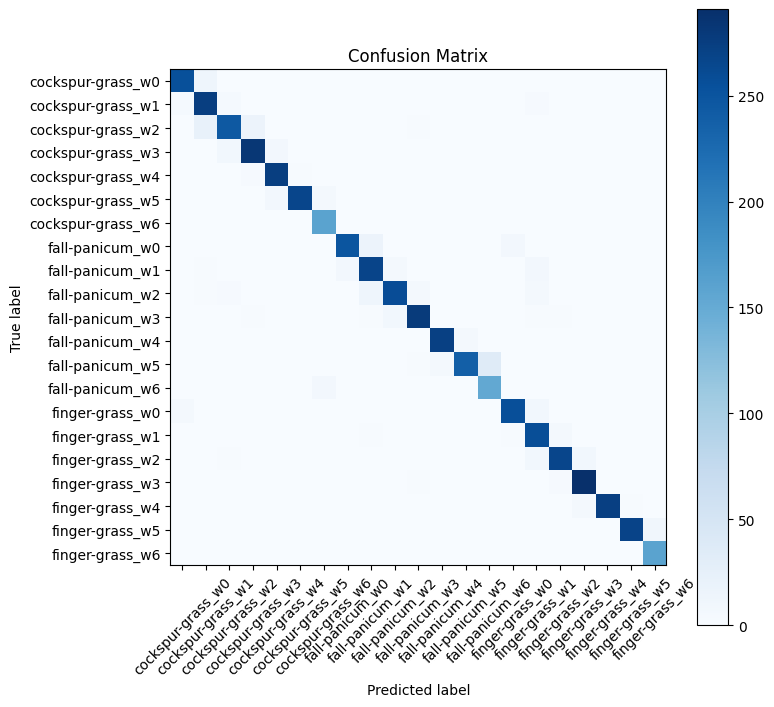

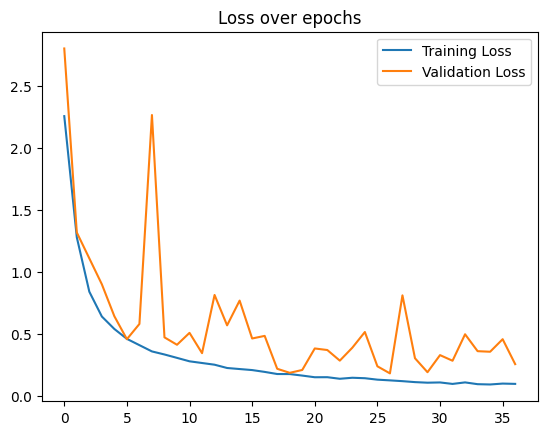

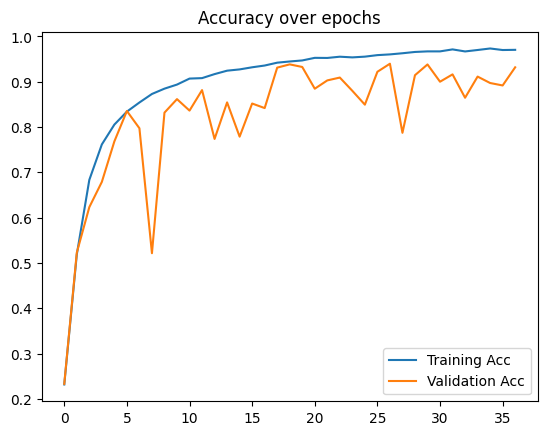

In [13]:
test_flow.reset()
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = list(test_flow.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
test_loss, test_acc = model.evaluate(test_flow, verbose=0)

# Precision, Recall, F1 (macro avg)
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]

# GFLOPS & Params
# flops = get_flops(model, batch_size=1)
num_params = model.count_params()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# print(f"GFLOPS: {flops/1e9:.4f}")
print(f"Parameters: {num_params}")

# Confusion Matrix 
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Loss/Accuracy Curves 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(); plt.title("Loss over epochs"); plt.show()
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.legend(); plt.title("Accuracy over epochs"); plt.show()


In [14]:
model.save('densenet_final_model.keras')
model.save_weights('densenet_final.weights.h5')

| Model       |   Params |   Test Loss |   Test Acc |   Precision |   Recall |    F1 |
|:------------|---------:|------------:|-----------:|------------:|---------:|------:|
| DenseNet121 |  8786005 |      0.1831 |     0.9423 |      0.9411 |   0.9451 | 0.942 |


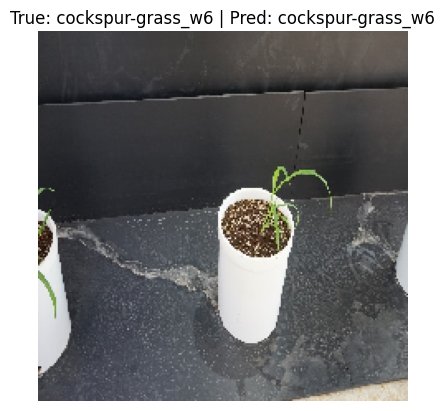

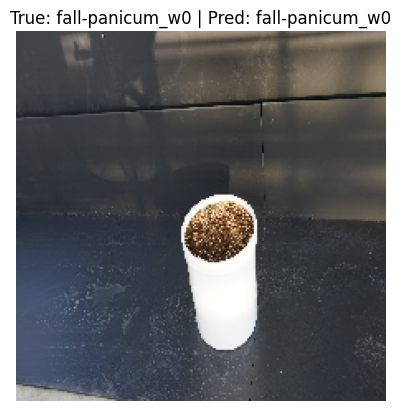

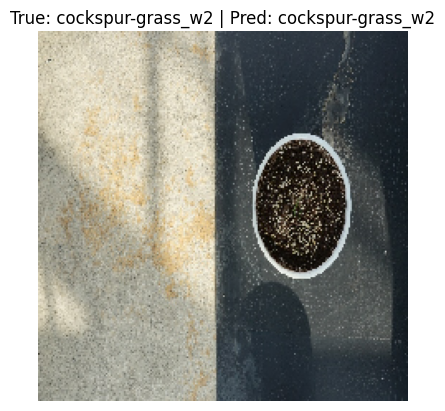

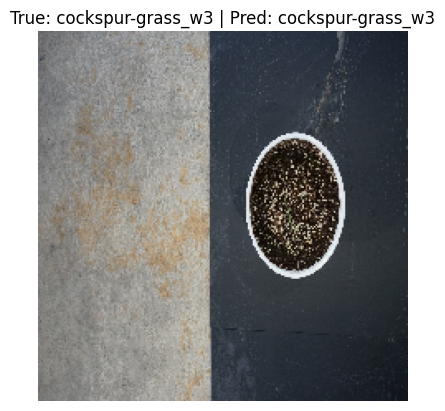

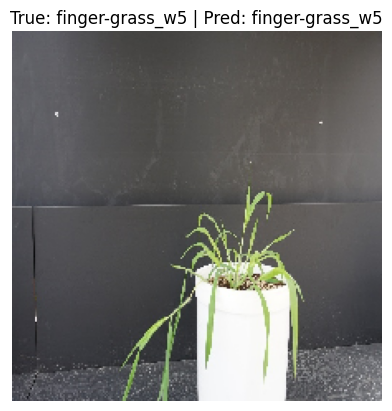

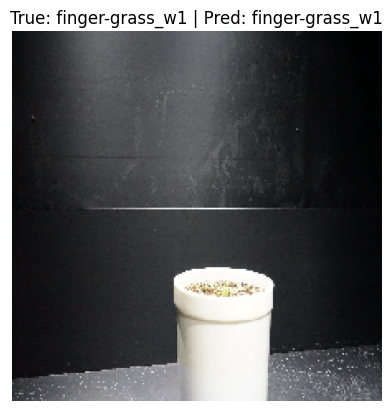

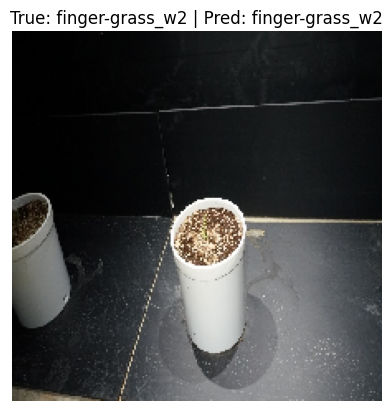

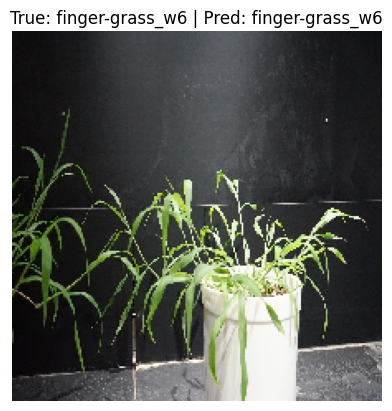

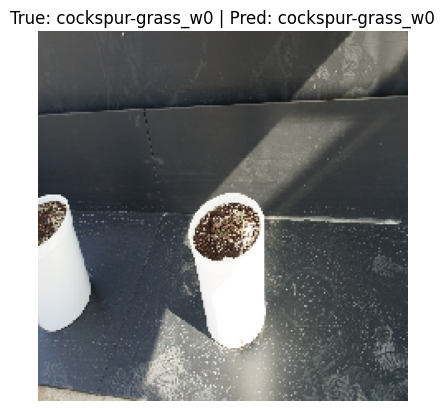

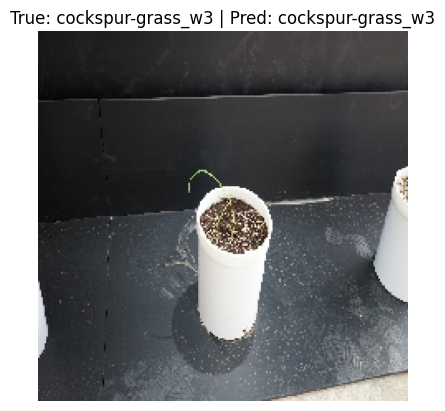

In [16]:
import pandas as pd
results = {
    "Model": ["DenseNet121"],
    "Params": [num_params],
    # "GFLOPS": [f"{flops/1e9:.4f}"],
    "Test Loss": [f"{test_loss:.4f}"],
    "Test Acc": [f"{test_acc:.4f}"],
    "Precision": [f"{precision:.4f}"],
    "Recall": [f"{recall:.4f}"],
    "F1": [f"{f1:.4f}"]
}
df = pd.DataFrame(results)
print(df.to_markdown(index=False))


import random
sample_idx = random.sample(range(test_flow.n), 10)
for idx in sample_idx:
    img_path = test_flow.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    true_label = target_names[y_true[idx]]
    pred_label = target_names[y_pred[idx]]
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()